## ResNet Configured in PyTorch: Training Demo on [*Dataset]

### Updated Notes:
- Training Loss decreases and spikes throughout each epoch
  - May be due to high learning rate that is missing the minima (https://stats.stackexchange.com/questions/201129/training-loss-goes-down-and-up-again-what-is-happening)

In [ ]:
# Libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
import os

import random

from tqdm.auto import tqdm
from sklearn.metrics import f1_score

In [ ]:
drive.mount('/content/gdrive')
print(os.listdir("/content/gdrive/MyDrive/archive/data/train"))
print(os.listdir("/content/gdrive/MyDrive/archive/data/test"))

Mounted at /content/gdrive
['benign', 'malignant']
['malignant', 'benign']


In [ ]:
train_dir="/content/gdrive/MyDrive/archive/data/train"
test_dir="/content/gdrive/MyDrive/archive/data/test"

In [ ]:
label=["malignant","benign"]

In [ ]:
# Create transform function to transform data
# This step involves the data augmentation and normalization of images

training_trans = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.CenterCrop((224, 224)),
    transforms.RandomHorizontalFlip(), # Ensures random orientation of images
    transforms.RandomApply([transforms.Lambda(lambda x: transforms.functional.rotate(x, random.choice([90, 180, 270])))]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])
test_trans = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.CenterCrop((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.Lambda(lambda x: transforms.functional.rotate(x, random.choice([90, 180, 270])))]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
train_data = datasets.ImageFolder(train_dir, training_trans)
test_data = datasets.ImageFolder(test_dir, test_trans)

print("Train Dataset Size: ", len(train_data))
print("Train Dataset Size: ", len(test_data))

Train Dataset Size:  2662
Train Dataset Size:  660


In [ ]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

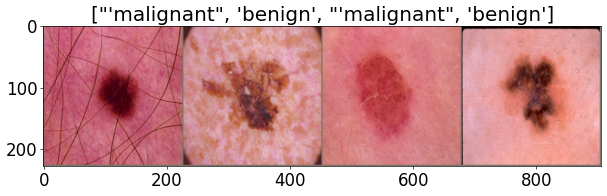

In [ ]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})
def imshow(input, title):
  # torch.Tensor => numpy (This part puts the parts of the image in the right format to display)
  input = input.numpy().transpose((1, 2, 0))

  # undo image normalization => To display the original image
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  input = std * input + mean
  input = np.clip(input, 0, 1)

  # display images
  plt.imshow(input)
  plt.title(title)
  plt.show()

# load a batch of train image
iterator = iter(train_dataloader)
# visualize a batch of training image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])


title = []
for x in classes[:4]:
  lab = x.item()
  title.append(label[lab])
imshow(out, title)

Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


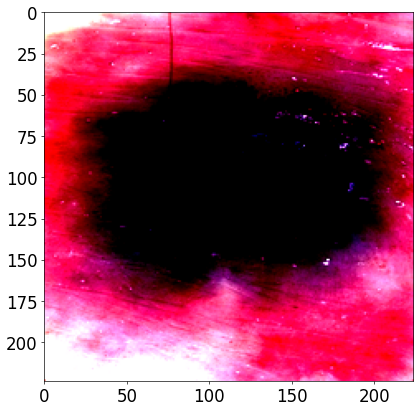

Label: 1


In [ ]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0]
label = train_labels[0]
img = img.numpy().transpose((1, 2, 0))
plt.imshow(img)
plt.show()
print(f"Label: {label}")

Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


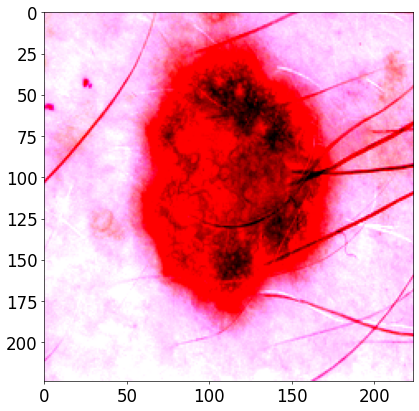

Label: 0


In [ ]:
test_features, test_labels = next(iter(test_dataloader))
print(f"Feature batch shape: {test_features.size()}")
print(f"Labels batch shape: {test_labels.size()}")
img = test_features[0]
label = test_labels[0]
img = img.numpy().transpose((1, 2, 0))
plt.imshow(img)
plt.show()
print(f"Label: {label}")

In [ ]:
# torchvision.models --> ResNet34 (Try other sizes and test later)
model = models.resnet34(weights='DEFAULT') # Using pre-trained model
model

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 171MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
model.fc = nn.Linear(512,2)
# Freeze all but last layer
for param in model.parameters():
  param.requires_grad = False
for param in model.fc.parameters():
  param.requires_grad = True
model # Check if last layer is updated for binary classification

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
batch_size = 64
epochs = 50
learning_rate = 3e-4

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model.to(device)

# Moving data to GPU
"""
for X, y in train_dataloader:
            X = X.to(device)
            y = y.to(device)

for X, y in test_dataloader:
            X = X.to(device)
            y = y.to(device)
"""

Using device: cuda


'\nfor X, y in train_dataloader:\n            X = X.to(device)\n            y = y.to(device)\n\nfor X, y in test_dataloader:\n            X = X.to(device)\n            y = y.to(device)\n'

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  # Set the model to training mode - important for batch normalization and dropout layers
  # Unnecessary in this situation but added for best practices
  progress_bar = tqdm(desc='training epoch', total=len(dataloader))

  model.train()
  for batch, (X, y) in enumerate(dataloader):

    # Moving Data to GPU
    X = X.to(device)
    y = y.to(device)

    pred = model(X)
    loss = loss_fn(pred, y)

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    progress_bar.update(1)

    # Display at start and at end
    if batch % (len(dataloader)-1) == 0:
        loss, current = loss.item(), batch * batch_size + len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")



def test_loop(dataloader, model, loss_fn):
  # Set the model to evaluation mode - important for batch normalization and dropout layers
  # Unnecessary in this situation but added for best practices
  model.eval()
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0, 0
  losses = []

  progress_bar = tqdm(desc='test loop', total=len(dataloader))
  preds = []
  labels = []

  # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
  # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
  with torch.no_grad():
    for X, y in dataloader:

      # Moving Data to GPU
      X = X.to(device)
      y = y.to(device)

      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      losses.append(loss_fn(pred, y).item())
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
      preds.extend(pred.argmax(1).cpu().numpy())
      labels.extend(y.cpu().numpy())

      progress_bar.update(1)

  test_loss /= num_batches
  correct /= size
  f1 = f1_score(labels, preds, average='weighted')
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
  print(f"F1 Accuracy: {f1:>0.4f} \n")
  plt.figure(figsize=(10, 5))

  plt.plot(losses, label='Loss', color='blue', marker='o')
  plt.title('Test Loss Over Batches')
  plt.xlabel('Batch Number')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid()
  plt.show()

In [ ]:
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train_loop(train_dataloader, model, loss_fn, optimizer)
  # test_loop(test_dataloader, model, loss_fn)
  if t % 10 == 0:
    test_loop(test_dataloader, model, loss_fn)
print("Training Complete.")


Epoch 1
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.716769  [   64/ 2662]
loss: 0.475701  [ 2662/ 2662]


test loop:   0%|          | 0/11 [00:00<?, ?it/s]

Test Error: 
 Accuracy: 72.6%, Avg loss: 0.537063 

F1 Accuracy: 0.7233 

Epoch 2
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.596357  [   64/ 2662]
loss: 0.435288  [ 2662/ 2662]
Epoch 3
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.488101  [   64/ 2662]
loss: 0.344319  [ 2662/ 2662]
Epoch 4
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.463043  [   64/ 2662]
loss: 0.534184  [ 2662/ 2662]
Epoch 5
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.615883  [   64/ 2662]
loss: 0.442161  [ 2662/ 2662]
Epoch 6
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.435783  [   64/ 2662]
loss: 0.306924  [ 2662/ 2662]
Epoch 7
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.390858  [   64/ 2662]
loss: 0.251853  [ 2662/ 2662]
Epoch 8
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.354707  [   64/ 2662]
loss: 0.355283  [ 2662/ 2662]
Epoch 9
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.372838  [   64/ 2662]
loss: 0.331446  [ 2662/ 2662]
Epoch 10
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.382538  [   64/ 2662]
loss: 0.359141  [ 2662/ 2662]
Epoch 11
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.497367  [   64/ 2662]
loss: 0.378732  [ 2662/ 2662]


test loop:   0%|          | 0/11 [00:00<?, ?it/s]

Test Error: 
 Accuracy: 84.7%, Avg loss: 0.376541 

F1 Accuracy: 0.8473 

Epoch 12
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.278827  [   64/ 2662]
loss: 0.342585  [ 2662/ 2662]
Epoch 13
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.387387  [   64/ 2662]
loss: 0.322558  [ 2662/ 2662]
Epoch 14
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.323524  [   64/ 2662]
loss: 0.254011  [ 2662/ 2662]
Epoch 15
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.379840  [   64/ 2662]
loss: 0.441544  [ 2662/ 2662]
Epoch 16
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.304796  [   64/ 2662]
loss: 0.520690  [ 2662/ 2662]
Epoch 17
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.313783  [   64/ 2662]
loss: 0.386058  [ 2662/ 2662]
Epoch 18
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.316707  [   64/ 2662]
loss: 0.222151  [ 2662/ 2662]
Epoch 19
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.371124  [   64/ 2662]
loss: 0.338605  [ 2662/ 2662]
Epoch 20
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.365279  [   64/ 2662]
loss: 0.356399  [ 2662/ 2662]
Epoch 21
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.418283  [   64/ 2662]
loss: 0.221433  [ 2662/ 2662]


test loop:   0%|          | 0/11 [00:00<?, ?it/s]

Test Error: 
 Accuracy: 83.3%, Avg loss: 0.360825 

F1 Accuracy: 0.8334 

Epoch 22
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.303061  [   64/ 2662]
loss: 0.246539  [ 2662/ 2662]
Epoch 23
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.325891  [   64/ 2662]
loss: 0.269301  [ 2662/ 2662]
Epoch 24
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.263892  [   64/ 2662]
loss: 0.447164  [ 2662/ 2662]
Epoch 25
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.388497  [   64/ 2662]
loss: 0.267368  [ 2662/ 2662]
Epoch 26
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.335152  [   64/ 2662]
loss: 0.254629  [ 2662/ 2662]
Epoch 27
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.374520  [   64/ 2662]
loss: 0.397126  [ 2662/ 2662]
Epoch 28
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.272667  [   64/ 2662]
loss: 0.240435  [ 2662/ 2662]
Epoch 29
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.370784  [   64/ 2662]
loss: 0.331194  [ 2662/ 2662]
Epoch 30
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.416023  [   64/ 2662]
loss: 0.426618  [ 2662/ 2662]
Epoch 31
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.263449  [   64/ 2662]
loss: 0.308653  [ 2662/ 2662]


test loop:   0%|          | 0/11 [00:00<?, ?it/s]

Test Error: 
 Accuracy: 84.4%, Avg loss: 0.342678 

F1 Accuracy: 0.8442 

Epoch 32
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.236055  [   64/ 2662]
loss: 0.392713  [ 2662/ 2662]
Epoch 33
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.300838  [   64/ 2662]
loss: 0.212229  [ 2662/ 2662]
Epoch 34
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.225513  [   64/ 2662]
loss: 0.295326  [ 2662/ 2662]
Epoch 35
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.372424  [   64/ 2662]
loss: 0.660855  [ 2662/ 2662]
Epoch 36
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.347231  [   64/ 2662]
loss: 0.323185  [ 2662/ 2662]
Epoch 37
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.507282  [   64/ 2662]
loss: 0.336834  [ 2662/ 2662]
Epoch 38
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.369512  [   64/ 2662]
loss: 0.337754  [ 2662/ 2662]
Epoch 39
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.271757  [   64/ 2662]
loss: 0.304930  [ 2662/ 2662]
Epoch 40
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.417000  [   64/ 2662]
loss: 0.300345  [ 2662/ 2662]
Epoch 41
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.370216  [   64/ 2662]
loss: 0.416858  [ 2662/ 2662]


test loop:   0%|          | 0/11 [00:00<?, ?it/s]

Test Error: 
 Accuracy: 84.5%, Avg loss: 0.331529 

F1 Accuracy: 0.8456 

Epoch 42
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.300258  [   64/ 2662]
loss: 0.388682  [ 2662/ 2662]
Epoch 43
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.261476  [   64/ 2662]
loss: 0.370087  [ 2662/ 2662]
Epoch 44
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.384009  [   64/ 2662]
loss: 0.337743  [ 2662/ 2662]
Epoch 45
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.227171  [   64/ 2662]
loss: 0.497748  [ 2662/ 2662]
Epoch 46
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.312943  [   64/ 2662]
loss: 0.283022  [ 2662/ 2662]
Epoch 47
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.323787  [   64/ 2662]
loss: 0.408356  [ 2662/ 2662]
Epoch 48
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.306688  [   64/ 2662]
loss: 0.378126  [ 2662/ 2662]
Epoch 49
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.271994  [   64/ 2662]
loss: 0.361016  [ 2662/ 2662]
Epoch 50
-------------------------------


training epoch:   0%|          | 0/42 [00:00<?, ?it/s]

loss: 0.273762  [   64/ 2662]
loss: 0.378652  [ 2662/ 2662]
Training Complete.


In [ ]:
# Load a model from model.pth for testing purposes

model = models.resnet34(weights='DEFAULT')
model.fc = nn.Linear(512,2)
# Freeze all but last layer
for param in model.parameters():
  param.requires_grad = False
for param in model.fc.parameters():
  param.requires_grad = True
model.load_state_dict(torch.load('/content/gdrive/MyDrive/AID/Models/model.pth'))


<ipython-input-13-cb7d1b3e88be>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/gdrive/MyDrive/AID/Models/model.pth'))


<All keys matched successfully>

test loop:   0%|          | 0/11 [00:00<?, ?it/s]

Test Error: 
 Accuracy: 85.0%, Avg loss: 0.356354 

F1 Accuracy: 0.8503 



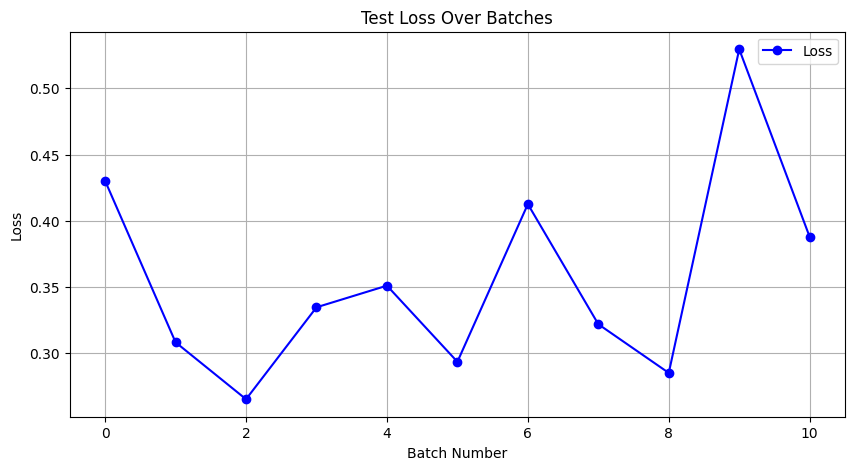

In [ ]:
test_loop(test_dataloader, model, loss_fn)

In [ ]:
diverse_data = datasets.ImageFolder("/content/gdrive/MyDrive/AID/Models/stanforddata", test_trans)
diverse_dataloader = DataLoader(diverse_data, batch_size=64, shuffle=True)
test_loop(diverse_dataloader, model, loss_fn)

test loop:   0%|          | 0/11 [00:00<?, ?it/s]

Test Error: 
 Accuracy: 36.0%, Avg loss: 1.363993 

F1 Accuracy: 0.3207 



In [ ]:
from google.colab import files
torch.save(model.state_dict(), 'model.pth')
files.download('model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


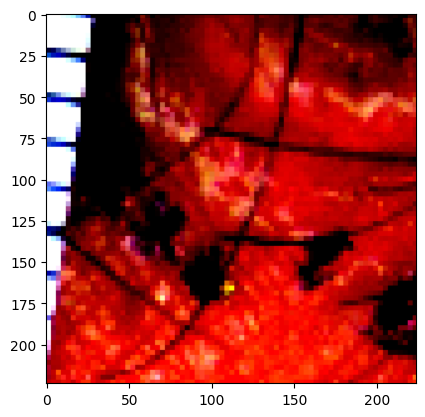

Label: 1


In [ ]:
diverse_data = datasets.ImageFolder("/content/gdrive/MyDrive/AID/Models/stanforddata", test_trans)
diverse_dataloader = DataLoader(diverse_data, batch_size=64, shuffle=True)
train_features, train_labels = next(iter(diverse_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")


img = train_features[0]
label = train_labels[0]
img = img.numpy().transpose((1, 2, 0))
plt.imshow(img)
plt.show()
print(f"Label: {label}")

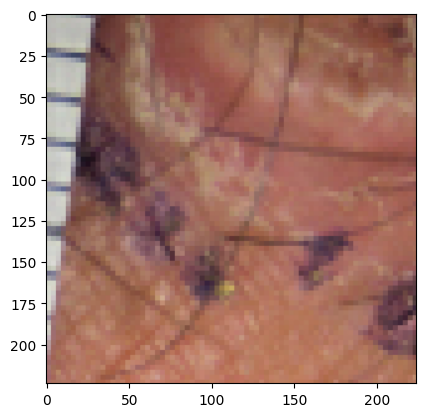

In [ ]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
input = std * img + mean
input = np.clip(input, 0, 1)

  # display images
plt.imshow(input)
plt.show()